# Pitch Type Model

### By: Jiso Awe


This project was intended to make a more accurate version of TrackMan's auto pitch type model, this is specifically made for college players.

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
plt.style.use('seaborn-whitegrid')

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [2]:
data = pd.read_csv('BattedBall.csv')
data.head(5)

,id,PitchNo,Date,Time,PAofInning,PitchofPA,PitcherId,PitcherThrows,PitcherTeam,BatterId,...,ThrowTrajectoryZc2,PitchReleaseConfidence,PitchLocationConfidence,PitchMovementConfidence,HitLaunchConfidence,HitLandingConfidence,CatcherThrowCatchConfidence,CatcherThrowReleaseConfidence,CatcherThrowLocationConfidence,GameID
0,6,6,2021-04-07,15:03:45,1,6,1.000080e+09,Right,TOW_TIG,1.000059e+09,...,NaN,High,High,High,Medium,Medium,NaN,NaN,NaN,57
1,16,16,2021-04-07,15:08:11,3,4,1.000080e+09,Right,TOW_TIG,1.000101e+09,...,NaN,High,High,High,High,High,NaN,NaN,NaN,57
2,32,32,2021-04-07,15:16:17,3,4,1.000025e+09,Right,NAV_MID,1.000059e+09,...,NaN,High,High,High,High,High,NaN,NaN,NaN,57
3,34,34,2021-04-07,15:18:22,1,2,1.000080e+09,Right,TOW_TIG,1.000013e+09,...,NaN,High,High,High,Medium,High,NaN,NaN,NaN,57
4,38,38,2021-04-07,15:19:48,2,4,1.000080e+09,Right,TOW_TIG,1.000059e+09,...,NaN,High,High,High,Medium,Medium,NaN,NaN,NaN,57


In [3]:
list(data.columns)

['id',
 'PitchNo',
 'Date',
 'Time',
 'PAofInning',
 'PitchofPA',
 'PitcherId',
 'PitcherThrows',
 'PitcherTeam',
 'BatterId',
 'BatterSide',
 'BatterTeam',
 'PitcherSet',
 'Inning',
 'TopOrBottom',
 'Outs',
 'Balls',
 'Strikes',
 'TaggedPitchType',
 'AutoPitchType',
 'PitchCall',
 'KorBB',
 'TaggedHitType',
 'PlayResult',
 'OutsOnPlay',
 'RunsScored',
 'Notes',
 'RelSpeed',
 'VertRelAngle',
 'HorzRelAngle',
 'SpinRate',
 'SpinAxis',
 'Tilt',
 'RelHeight',
 'RelSide',
 'Extension',
 'VertBreak',
 'InducedVertBreak',
 'HorzBreak',
 'PlateLocHeight',
 'PlateLocSide',
 'ZoneSpeed',
 'VertApprAngle',
 'HorzApprAngle',
 'ZoneTime',
 'ExitSpeed',
 'Angle',
 'Direction',
 'HitSpinRate',
 'PositionAt110X',
 'PositionAt110Y',
 'PositionAt110Z',
 'Distance',
 'LastTrackedDistance',
 'Bearing',
 'HangTime',
 'pfxx',
 'pfxz',
 'x0',
 'y0',
 'z0',
 'vx0',
 'vy0',
 'vz0',
 'ax0',
 'ay0',
 'az0',
 'HomeTeam',
 'AwayTeam',
 'Stadium',
 'Level',
 'League',
 'TrackmanGameID',
 'PitchUID',
 'EffectiveVel

### Movement Plots

I created the movement plots for both left and right handed pitchers, to highlight the difference in their movement profiles. Traditionally in baseball velocity in combination with horizontal and induced vertical breaks to categorize the pitch.

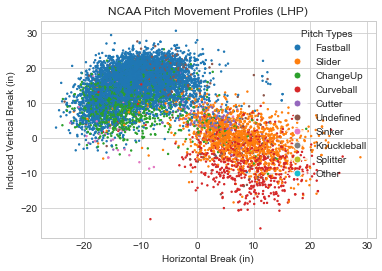

In [58]:
#leftie pitch plots
dataL = data[data['PitcherThrows'] == "Left"]
xL = dataL['HorzBreak']
yL = dataL['InducedVertBreak']
zL = dataL['TaggedPitchType']

pitch_types = zL.unique()

color_map = plt.get_cmap('tab10')
color_dict = {pitch_type: colors(i) for i, pitch_type in enumerate(pitch_types)}

color_values = [color_dict[pitch_type] for pitch_type in zL]


scatter = plt.scatter(xL, yL, c = color_values, s = 2, label = zL)

plt.title("NCAA Pitch Movement Profiles (LHP)")
plt.ylabel("Induced Vertical Break (in)")
plt.xlabel("Horizontal Break (in)")

handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map(i / len(pitch_types)), markersize=7) for i, pitch_type in enumerate(pitch_types)]
labels = pitch_types
plt.legend(handles, labels, title = 'Pitch Types')
plt.show()

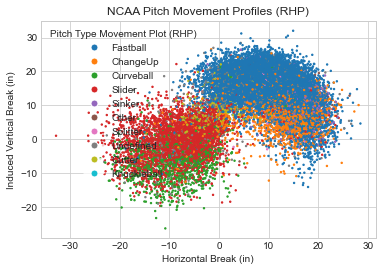

In [59]:
#rightie pitch plots
dataR = data[data['PitcherThrows'] == "Right"]
xR = dataR['HorzBreak']
yR = dataR['InducedVertBreak']
zR = dataR['TaggedPitchType']

pitch_types = zR.unique()

color_map = plt.get_cmap('tab10')
color_dict = {pitch_type: colors(i) for i, pitch_type in enumerate(pitch_types)}

color_values = [color_dict[pitch_type] for pitch_type in zR]


scatter = plt.scatter(xR, yR, c = color_values, s = 2, label = zR)

plt.title("NCAA Pitch Movement Profiles (RHP)")
plt.ylabel("Induced Vertical Break (in)")
plt.xlabel("Horizontal Break (in)")

handles = [plt.Line2D([0], [0], marker='o', 
                      color='w', 
                      markerfacecolor=color_map(i / len(pitch_types)), 
                      markersize=7) for i, 
           pitch_type in enumerate(pitch_types)]

labels = pitch_types
plt.legend(handles, labels, title = 'Pitch Type Movement Plot (RHP)')
plt.show()

In [4]:
cols = ['PitcherThrows', 'RelSpeed', 'VertRelAngle', 'HorzRelAngle', 'SpinRate', 'SpinAxis',
            'RelHeight', 'RelSide', 'Extension', 'VertBreak', 'InducedVertBreak', 'HorzBreak', 'ZoneSpeed',
           'VertApprAngle', 'HorzApprAngle', 'PitchTrajectoryXc0','PitchTrajectoryXc1', 'PitchTrajectoryXc2',
            'PitchTrajectoryYc0', 'PitchTrajectoryYc1', 'PitchTrajectoryYc2', 'PitchTrajectoryZc0',
            'PitchTrajectoryZc1','PitchTrajectoryZc2', 'TaggedPitchType'] #'Tilt', ]

updated_df = data[cols]


In [5]:
one_hot_encoded_data = pd.get_dummies(updated_df, columns = ['PitcherThrows'])
print(one_hot_encoded_data.head(5))

   RelSpeed  VertRelAngle  HorzRelAngle  SpinRate  SpinAxis  RelHeight  \
0   87.7942     -2.316140      -1.48219   2074.21   193.273    6.39639   
1   78.6510     -3.237650      -2.15585   1743.14   176.354    6.21378   
2   83.7694     -0.945851      -3.61505   2063.13   194.331    5.58439   
3   87.2288     -2.433030      -1.51020   2049.19   183.578    6.36527   
4   88.3147     -3.345550      -1.49199   2083.12   195.554    6.32208   

   RelSide  Extension  VertBreak  InducedVertBreak  ...  PitchTrajectoryXc2  \
0  1.25232    5.62407   -14.4967           22.7111  ...             14.9429   
1  1.55537    5.58387   -20.2948           26.5170  ...             12.5362   
2  2.96050    6.79323   -21.0996           17.8128  ...             13.0979   
3  1.16780    5.48250   -12.4688           25.7406  ...             15.7290   
4  1.41026    5.61121   -13.4307           23.4954  ...             15.3537   

   PitchTrajectoryYc0  PitchTrajectoryYc1  PitchTrajectoryYc2  \
0             6

In [6]:
one_hot_encoded_data.dropna(inplace=True)

In [7]:
one_hot_encoded_data.head(5)

,RelSpeed,VertRelAngle,HorzRelAngle,SpinRate,SpinAxis,RelHeight,RelSide,Extension,VertBreak,InducedVertBreak,...,PitchTrajectoryXc2,PitchTrajectoryYc0,PitchTrajectoryYc1,PitchTrajectoryYc2,PitchTrajectoryZc0,PitchTrajectoryZc1,PitchTrajectoryZc2,TaggedPitchType,PitcherThrows_Left,PitcherThrows_Right
0,87.7942,-2.316140,-1.48219,2074.21,193.273,6.39639,1.25232,5.62407,-14.4967,22.7111,...,14.9429,6.39219,-5.07470,-5.88970,-1.25003,3.25817,-2.44303,Fastball,0,1
1,78.6510,-3.237650,-2.15585,1743.14,176.354,6.21378,1.55537,5.58387,-20.2948,26.5170,...,12.5362,6.20956,-6.39518,-6.43732,-1.55554,4.33739,0.04007,ChangeUp,0,1
2,83.7694,-0.945851,-3.61505,2063.13,194.331,5.58439,2.96050,6.79323,-21.0996,17.8128,...,13.0979,5.58271,-1.97702,-8.59524,-2.95833,7.68082,-2.47728,Fastball,0,1
3,87.2288,-2.433030,-1.51020,2049.19,183.578,6.36527,1.16780,5.48250,-12.4688,25.7406,...,15.7290,6.36003,-5.26725,-4.85992,-1.16691,3.34104,-1.01793,Fastball,0,1
4,88.3147,-3.345550,-1.49199,2083.12,195.554,6.32208,1.41026,5.61121,-13.4307,23.4954,...,15.3537,6.31744,-7.41420,-5.19747,-1.40755,3.28298,-2.93283,Fastball,0,1


In [8]:
y = one_hot_encoded_data['TaggedPitchType']

X = one_hot_encoded_data.drop('TaggedPitchType', axis = 1)


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 22)

## KNN

In [10]:
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

In [11]:
accuracy_score(y_test, y_pred_knn)

0.8046798830029249

## SVM

In [12]:
svc = SVC(kernel = 'rbf', random_state = 2)
svc.fit(X_train, y_train)
y_pred_SVC = svc.predict(X_test)

In [13]:
accuracy_score(y_test, y_pred_SVC)

0.7549561260968476

# Naive Bayes

In [14]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred_gnb = gnb.predict(X_test)

In [15]:
accuracy_score(y_test, y_pred_gnb)

0.7173653991983534

# Decison Tree

In [16]:
clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred_clf = clf.predict(X_test)

In [17]:
accuracy_score(y_test, y_pred_clf)

0.7911385548694616

# KNN Optimized

After examining the baseline classifier models, KNN performed the best with a ~0.8047 accuracy score. Now to test different ways to optimize for better performance.

Text(0, 0.5, 'Error Rate')

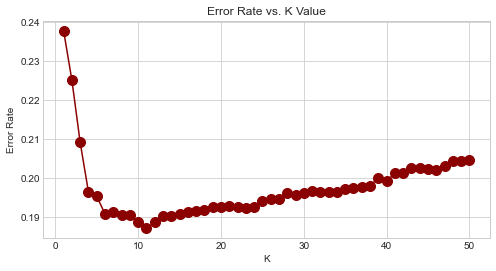

In [18]:
error_rate = []
for i in range(1,51):    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))
    
## creating a graph to examine which value for n has the lowest error
plt.figure(figsize=(8,4))
plt.plot(range(1,51),error_rate,color='darkred', marker='o',markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [19]:
knn2 = KNeighborsClassifier(n_neighbors = 11)
knn2.fit(X_train, y_train)
knn_pred = knn2.predict(X_test)
accuracy_score(y_test, knn_pred)

0.8129130105080706

In [20]:
parameters = {'n_neighbors': range(7,13),
             'weights':['uniform', 'distance'],
             'algorithm':['auto', 'kd_tree'],
             'leaf_size': range(30,35)}

stratified_k_fold = StratifiedKFold(n_splits = 5)

grid_search = GridSearchCV(estimator = KNeighborsClassifier(),
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = stratified_k_fold,
                           return_train_score = True,
                          n_jobs=-1)


In [23]:
grid_search.fit(X_train, y_train)

/Users/jisoluawe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'algorithm': ['auto', 'kd_tree'],
                         'leaf_size': range(30, 35),
                         'n_neighbors': range(7, 13),
                         'weights': ['uniform', 'distance']},
             return_train_score=True, scoring='accuracy')

In [24]:
best_params = grid_search.best_params_
print("The best parameters are:", best_params)

The best parameters are: {'algorithm': 'auto', 'leaf_size': 30, 'n_neighbors': 9, 'weights': 'distance'}


In [25]:
optKNN = grid_search.predict(X_test)

In [26]:
accuracy_score(y_test, optKNN)


0.8198461705124038